In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (precision_recall_curve, average_precision_score, roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier

try:
    import xgboost as xgb
except Exception as e:
    xgb = None
    print('XGBoost not available: ', e)
try:
    import lightgbm as lgb
except Exception as e:
    lgb = None
    print('LightGBM not available:', e)

import joblib
print('Setup complete')


Setup complete


In [ ]:
DATA_PATH = 'creditcard.csv'
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Please place creditcard.csv next to the notebook."
df = pd.read_csv(DATA_PATH)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Rows, Columns: (284807, 31)
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Missing values (top 20): 
 Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
V13     0
V14     0
V15     0
V16     0
V17     0
V18     0
V19     0
dtype: int64

Target distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud ratio: 0.001727485630620034


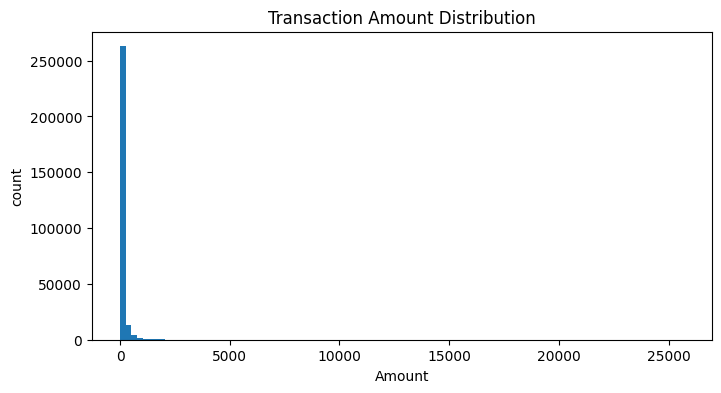

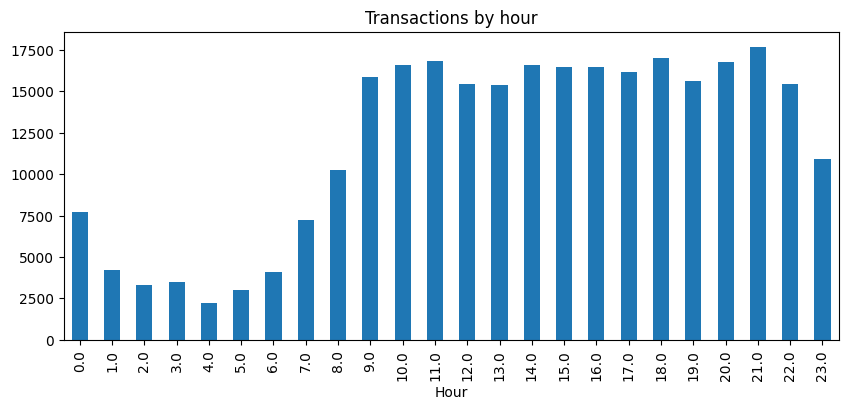

In [ ]:
print('Rows, Columns:', df.shape)
print(df.dtypes)
print('\nMissing values (top 20): \n', df.isnull().sum().sort_values(ascending=False).head(20))
target_col = 'Class'
print('\nTarget distribution:')
print(df[target_col].value_counts())
print('Fraud ratio:', df[target_col].mean())

plt.figure(figsize=(8,4))
plt.hist(df['Amount'], bins=100)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('count')
plt.show()

if 'Time' in df.columns:
    df['Hour'] = (df['Time'] // 3600) % 24
    plt.figure(figsize=(10,4))
    df.groupby('Hour').size().plot(kind='bar')
    plt.title('Transactions by hour')
    plt.show()

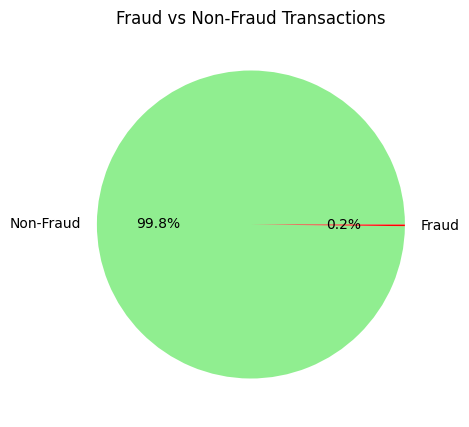

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(df['Class'].value_counts().values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['lightgreen', 'red'])
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()


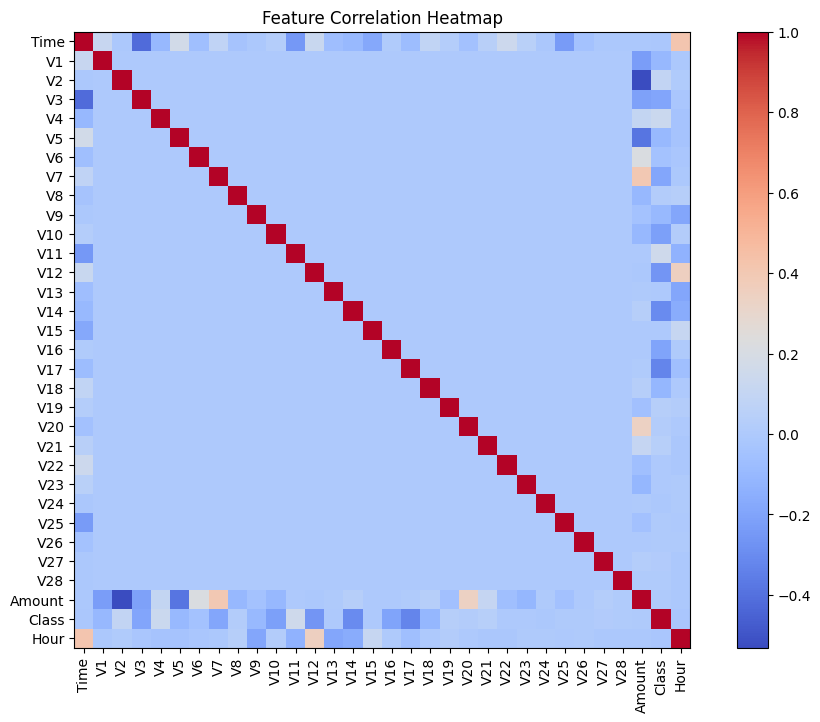

In [ ]:
plt.figure(figsize=(12,8))
corr = df.corr()
plt.imshow(corr, cmap='coolwarm', interpolation = 'nearest')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Feature Correlation Heatmap')
plt.show()

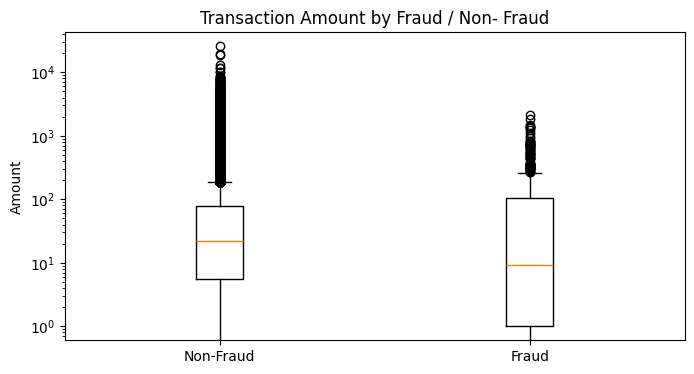

In [ ]:
plt.figure(figsize=(8,4))
amount_nonfraud = df[df['Class']==0]['Amount']
amount_fraud = df[df['Class']==1]['Amount']
plt.boxplot([amount_nonfraud, amount_fraud], labels=['Non-Fraud', 'Fraud'])
plt.yscale('log')
plt.ylabel('Amount')
plt.title('Transaction Amount by Fraud / Non- Fraud')
plt.show()

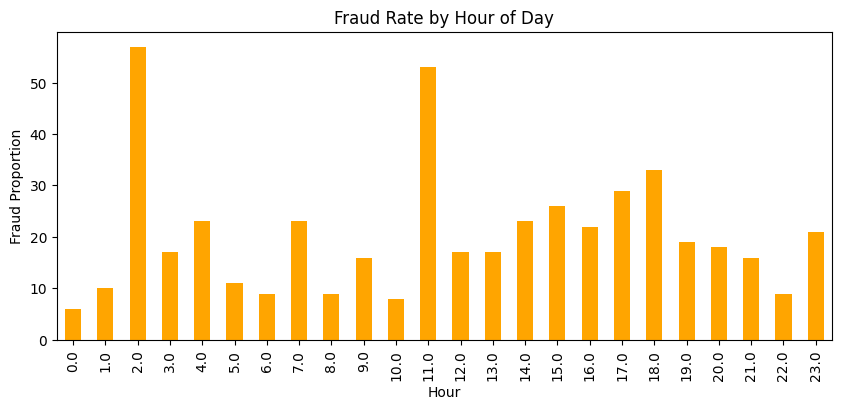

In [ ]:
hourly = df.groupby('Hour')['Class'].sum()
plt.figure(figsize=(10,4))
hourly.plot(kind='bar', color='orange')
plt.ylabel('Fraud Proportion')
plt.title('Fraud Rate by Hour of Day')
plt.show()

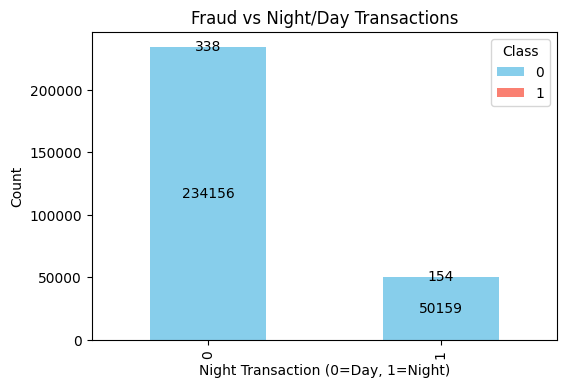

In [ ]:
df['is_night'] = df['Hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)

night_fraud = df.groupby(['is_night','Class']).size().unstack(fill_value=0)
ax = night_fraud.plot(kind='bar',stacked=True,figsize=(6,4),color=['skyblue','salmon'])
plt.xlabel('Night Transaction (0=Day, 1=Night)')
plt.ylabel('Count')
plt.title('Fraud vs Night/Day Transactions')
for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%d')
plt.show()

In [ ]:
df_fe = df.copy()
df_fe['log_amount'] = np.log1p(df_fe['Amount'])
global_mean = df_fe['Amount'].mean()
df_fe['amount_to_mean'] = df_fe['Amount'] / (global_mean + 1e-9)
p99 = df_fe['Amount'].quantile(0.99)
df_fe['is_high_amount'] = (df_fe['Amount'] > p99).astype(int)

if 'Hour' in df_fe.columns:
    df_fe['is_night'] = df_fe['Hour'].isin([0,1,2,3,4,5,22,23]).astype(int)
else:
    df_fe['is_night'] = 0

X = df_fe.drop(columns=[target_col])
y = df_fe[target_col].values

print('Feature engineering complete. X shape: ', X.shape)

Feature engineering complete. X shape:  (284807, 35)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train: ', X_train.shape, 'Test:', X_test.shape)

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = RobustScaler()
scaler.fit(X_train[numeric_features])

def prep(X_df):
    Xc = X_df.copy()
    Xc[numeric_features] = scaler.transform(Xc[numeric_features])
    if 'Time' in Xc.columns:
        Xc = Xc.drop(columns=['Time'])
    return Xc

X_train_proc = prep(X_train)
X_test_proc = prep(X_test)
print('Processed data shapes:', X_train_proc.shape, X_test_proc.shape)

Train:  (227845, 35) Test: (56962, 35)
Processed data shapes: (227845, 34) (56962, 34)


In [ ]:
def evaluate_model(model, X_test, y_test, thresh=0.5, show_pr_curve=True):

    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:,1]
    elif hasattr(model, 'decision_function'):
        s = model.decision_function(X_test)
        y_scores = (s - s.min())/(s.max()-s.min()+1e-9)
    else:
        y_scores = model.predict(X_test)
    y_pred = (y_scores >= thresh).astype(int)
    print('Classification report (threshold={}):'.format(thresh))
    print(classification_report(y_test, y_pred, digits=4))
    ap = average_precision_score(y_test, y_scores)
    roc = roc_auc_score(y_test, y_scores)
    cm = confusion_matrix(y_test, y_pred)
    print('Average precision (AUPRC):', ap)
    print('ROC AUC:', roc)
    print('Confusion matrix:\n', cm)
    if show_pr_curve:
        precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
        plt.figure(figsize=(6,4))
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'PR curve (AP={ap:.4f})')
        plt.show()
    return {'ap': ap, 'roc': roc, 'scores': y_scores}

In [ ]:
# Models training
trained_models = {}

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train_proc, y_train)
trained_models['RandomForest'] = rf
print('Trained Random Forest')

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(np.sum(y_train==0)/np.sum(y_train==1)))
xgb_clf.fit(X_train_proc, y_train)
trained_models['XGBoost'] = xgb_clf
print('Trained XGBoost')


=== Model: RandomForest ===
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9615    0.7653    0.8523        98

    accuracy                         0.9995     56962
   macro avg     0.9806    0.8826    0.9260     56962
weighted avg     0.9995    0.9995    0.9995     56962

Average precision (AUPRC): 0.8689747438567735
ROC AUC: 0.9572644864079565
Confusion matrix:
 [[56861     3]
 [   23    75]]


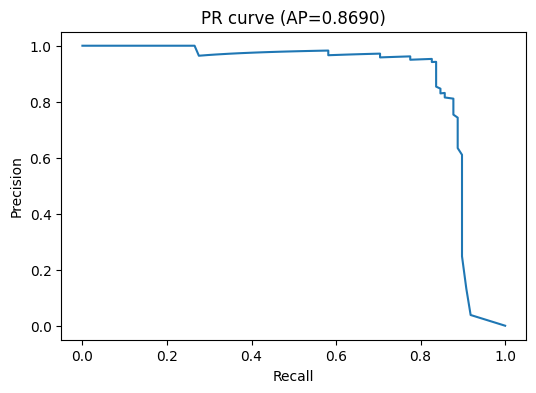


=== Model: XGBoost ===
Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8791    0.8163    0.8466        98

    accuracy                         0.9995     56962
   macro avg     0.9394    0.9081    0.9232     56962
weighted avg     0.9995    0.9995    0.9995     56962

Average precision (AUPRC): 0.8802943133763177
ROC AUC: 0.9767434724311784
Confusion matrix:
 [[56853    11]
 [   18    80]]


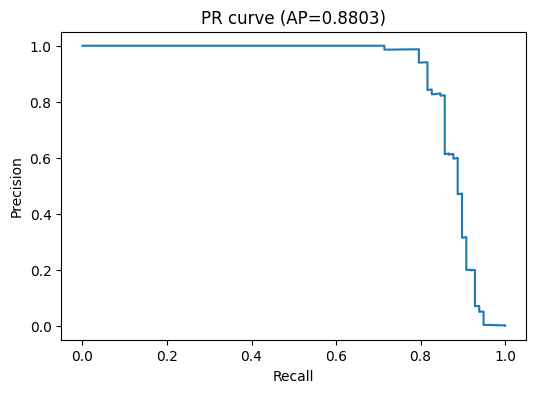

,model,AP,ROC_AUC
1,XGBoost,0.880294,0.976743
0,RandomForest,0.868975,0.957264


In [ ]:
results = []
for name, model in trained_models.items():
    print('\n=== Model:', name, '===')
    res = evaluate_model(model, X_test_proc, y_test)
    results.append({'model': name, 'AP': res['ap'], 'ROC_AUC': res['roc']})

res_df = pd.DataFrame(results).sort_values('AP', ascending=False)
res_df

In [ ]:
best_model_name = res_df.iloc[0]['model']
model = trained_models[best_model_name]
print('Best model chosen:', best_model_name)

if hasattr(model, 'predict_proba'):
    y_scores = model.predict_proba(X_test_proc)[:,1]
else:
    s = model.decision_function(X_test_proc)
    y_scores = (s - s.min())/(s.max()-s.min()+1e-9)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
print('Best threshold by F1 on test:', best_thresh)

X_all_proc = prep(X)
if hasattr(model, 'predict_proba'):
    all_scores = model.predict_proba(X_all_proc)[:,1]
else:
    s = model.decision_function(X_all_proc)
    all_scores = (s - s.min())/(s.max()-s.min()+1e-9)

df_out = df_fe.copy()
df_out['fraud_score'] = all_scores
df_out['pred_fraud'] = (df_out['fraud_score'] >= best_thresh).astype(int)
flagged = df_out[df_out['pred_fraud'] == 1].sort_values('fraud_score', ascending=False)
print('Flagged transactions count:', len(flagged))
flagged.head(20).to_csv('flagged_transactions.csv', index=False)
print('Saved flagged transactions to flagged_transactions.csv')

Best model chosen: XGBoost
Best threshold by F1 on test: 0.99290437
Flagged transactions count: 473
Saved flagged transactions to flagged_transactions.csv


In [ ]:
joblib.dump(model, 'best_fraud_model.pkl')
print('Saved best model to best_fraud_model.pkl')

Saved best model to best_fraud_model.pkl
